In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar -xzf spark-3.5.0-bin-hadoop3.tgz

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

!pip install -q pyspark==3.5.0
!pip install -q graphframes

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("GraphFramesApp") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.4-spark3.5-s_2.12") \
    .getOrCreate()

print("Spark & GraphFrames loaded!")


Spark & GraphFrames loaded!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("App").master("local").getOrCreate()

file_path = "/content/drive/MyDrive/pubmed_final_dataset.parquet"

df_pubmed = spark.read.parquet(file_path)
df_pubmed.show(truncate=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df_pubmed.count()

24919

 (Authors ↔ Papers)

In [ ]:
from pyspark.sql.functions import explode, col, lit
from graphframes import GraphFrame

df_exploded = df_pubmed.withColumn("Author", explode(col("Author_Names")))

authors = df_exploded.select(col("Author").alias("id")).distinct().withColumn("type", lit("author"))
papers = df_exploded.select(col("PMID").cast("string").alias("id")).distinct().withColumn("type", lit("paper"))
vertices = authors.union(papers).distinct()

edges = df_exploded.select(
    col("Author").alias("src"),
    col("PMID").cast("string").alias("dst")
)

g_pubmed = GraphFrame(vertices, edges)

g_pubmed.vertices.show(25,truncate=False)
g_pubmed.edges.show(25,truncate=False)


+---------------------------+------+
|id                         |type  |
+---------------------------+------+
|Jyuichi Sakamoto           |author|
|Felipe David Mendonça Chaim|author|
|I V Kudryakova             |author|
|Arthur P Schwab            |author|
|Sourav Maiti               |author|
|Ranjith K Nair             |author|
|Julien Mayaux              |author|
|C Muñoz-Calleja            |author|
|Sylvie Nadeau              |author|
|Irma Dewiyanti             |author|
|Kumar Sudesh               |author|
|Shuhei Koeda               |author|
|Guy D Leschziner           |author|
|Nadeeka K Wawegama         |author|
|Roberto Silva              |author|
|Bill McFadden              |author|
|Hélder A Santos            |author|
|Mario F Feldman            |author|
|Georg Bergmann             |author|
|Christoph Zenzmaier        |author|
|Mika Kivimäki              |author|
|Reuven Achiron             |author|
|Takashi Tanimoto           |author|
|D M Fobes                  |author|
|

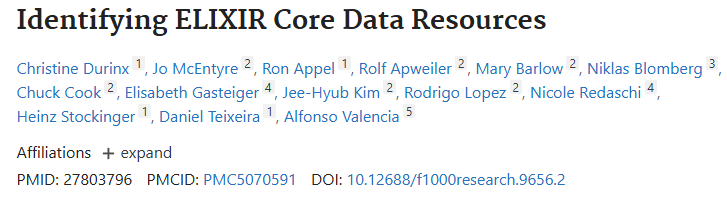

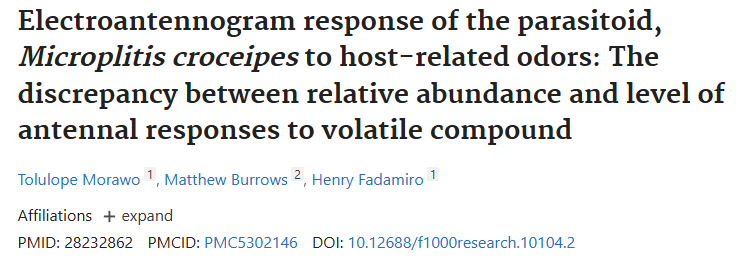

The bipartite graph between authors and papers represents the relationship where each author is connected to the papers they have contributed to. This structure enables analysis of collaboration patterns, identification of influential researchers, and understanding of how scientific knowledge is produced and shared.

In [ ]:
df_pubmed.columns

['PMID',
 'Title',
 'Abstract',
 'Year',
 'Journal',
 'PublicationType',
 'Author_Names',
 'Keywords',
 'MeshHeadings',
 'Chemicals',
 'References',
 'Reference_Count',
 'CitedBy',
 'CitedBy_Count']

In [ ]:
df_pubmed.cache()

DataFrame[PMID: string, Title: string, Abstract: string, Year: string, Journal: string, PublicationType: array<string>, Author_Names: array<string>, Keywords: array<string>, MeshHeadings: array<string>, Chemicals: array<string>, References: array<struct<citation:string,pmid:string>>, Reference_Count: int, CitedBy: array<string>, CitedBy_Count: int]

The below graph links keywords to the articles they describe, enabling semantic search, clustering by topic, and ontology exploration.

In [ ]:
# MeSH ↔ Paper Graph Example
from pyspark.sql.functions import explode, lit

# Explode MeSH terms
df_mesh = df_pubmed.withColumn("Mesh", explode(col("MeshHeadings")))

vertices_mesh = df_mesh.select(col("PMID").cast("string").alias("id")).distinct().withColumn("type", lit("paper")) \
    .union(df_mesh.select(col("Mesh").alias("id")).distinct().withColumn("type", lit("mesh"))).distinct()

edges_mesh = df_mesh.select(col("Mesh").alias("src"), col("PMID").cast("string").alias("dst"))

g_mesh = GraphFrame(vertices_mesh, edges_mesh)

print("🔸 Vertices (MeSH and Papers):")
g_mesh.vertices.show(20, truncate=False)

print("🔹 Edges (Mesh ↔ Paper):")
g_mesh.edges.show(20, truncate=False)

print("\n📥 In-Degrees (Popular MeSH):")
g_mesh.inDegrees.orderBy("inDegree", ascending=False).show(20)


🔸 Vertices (MeSH and Papers):
+--------+-----+
|id      |type |
+--------+-----+
|28352857|paper|
|28369545|paper|
|28355868|paper|
|28363052|paper|
|28362560|paper|
|28363172|paper|
|28372353|paper|
|28357628|paper|
|28361679|paper|
|28359511|paper|
|28349713|paper|
|28345292|paper|
|28360127|paper|
|28372867|paper|
|28349399|paper|
|28347835|paper|
|28355356|paper|
|28348168|paper|
|28355967|paper|
|28356113|paper|
+--------+-----+
only showing top 20 rows

🔹 Edges (Mesh ↔ Paper):
+--------------------------------------------------+--------+
|src                                               |dst     |
+--------------------------------------------------+--------+
|Chromatography, Gas  [, methods, ]                |28343685|
|Models, Theoretical                               |28343685|
|Pressure                                          |28343685|
|Reproducibility of Results                        |28343685|
|Temperature                                       |28343685|
|Allergens  [, a

In this step, we constructed a MeSH ↔ Paper bipartite graph from the PubMed dataset, where each node represents either a scientific article (PMID) or a MeSH (Medical Subject Heading) term, and each edge links a paper to one of its associated MeSH terms. This graph-based representation enables us to identify the most frequently used MeSH topics (via in-degree), detect articles that span multiple biomedical domains (via out-degree), and uncover semantically related articles through shared topics. Overall, this approach provides a powerful way to extract semantic insights and thematic structures from the data without relying on traditional NLP techniques.

In [ ]:
from pyspark.sql.functions import col, size, explode

unique_mesh_terms = df_pubmed.selectExpr("explode(MeshHeadings) as Mesh").select("Mesh").distinct().count()

papers_with_many_mesh = df_pubmed.select("PMID", "Title", size("MeshHeadings").alias("mesh_count")) \
                                 .orderBy("mesh_count", ascending=False)

popular_mesh_terms = df_pubmed.withColumn("Mesh", explode("MeshHeadings")) \
                              .groupBy("Mesh") \
                              .count() \
                              .orderBy("count", ascending=False)

In [ ]:
popular_mesh_terms.show()

+--------------------+-----+
|                Mesh|count|
+--------------------+-----+
|            Humans  |13281|
|            Female  | 7661|
|              Male  | 7511|
|           Animals  | 4525|
|             Adult  | 4172|
|       Middle Aged  | 4132|
|              Aged  | 3040|
|       Young Adult  | 1949|
|        Adolescent  | 1623|
|Retrospective Stu...| 1355|
| Treatment Outcome  | 1260|
|              Mice  | 1244|
| Aged, 80 and over  | 1180|
|             Child  | 1076|
|      Risk Factors  |  995|
|      Time Factors  |  813|
|Prospective Studi...|  758|
|Cross-Sectional S...|  639|
|Surveys and Quest...|  629|
|  Child, Preschool  |  617|
+--------------------+-----+
only showing top 20 rows



Most Frequent MeSH Terms: Terms such as "Humans", "Female", "Male", and "Animals" dominate the dataset, appearing in thousands of publications. These high-frequency terms represent general biomedical categories, suggesting that they are foundational descriptors applied across a wide range of studies. Their prominence may be due to indexing conventions or their relevance across multiple medical contexts.

In [ ]:
import pandas as pd

(unique_mesh_terms, papers_with_many_mesh_pd) = (unique_mesh_terms, papers_with_many_mesh.limit(20).toPandas())

pd.set_option('display.max_colwidth', None)
papers_with_many_mesh_pd

,PMID,Title,mesh_count
0,28360015,Health-related quality of life in patients with locally recurrent or metastatic breast cancer treated with etirinotecan pegol versus treatment of physician's choice: Results from the randomised phase III BEACON trial.,37
1,28369832,A comprehensive comparative analysis of treatment modalities for sinonasal malignancies.,35
2,28347868,"Teneligliptin, a dipeptidyl peptidase-4 inhibitor, attenuated pro-inflammatory phenotype of perivascular adipose tissue and inhibited atherogenesis in normoglycemic apolipoprotein-E-deficient mice.",34
3,28350519,Outcome of Lower-Risk Patients With Myelodysplastic Syndromes Without 5q Deletion After Failure of Erythropoiesis-Stimulating Agents.,34
4,28367666,"Suppression of VEGF-induced angiogenesis and tumor growth by Eugenia jambolana, Musa paradisiaca, and Coccinia indica extracts.",34
5,28359095,"Radiotherapy, Especially at Young Age, Increases the Risk for De Novo Brain Tumors in Patients Treated for Pituitary/Sellar Lesions.",33
6,28359102,Surgery for Neck Recurrence of Differentiated Thyroid Cancer: Outcomes and Risk Factors.,33
7,28365917,The Protective Effects of Helix B Surface Peptide on Experimental Acute Liver Injury Induced by Carbon Tetrachloride.,32
8,28366300,Distal embolization during lower extremity endovascular interventions.,32
9,28347271,The ST131 Escherichia coli H22 subclone from human intestinal microbiota: Comparison of genomic and phenotypic traits with those of the globally successful H30 subclone.,31


Papers with High MeSH Diversity: Some papers are linked to more than 30 distinct MeSH terms, indicating they cover a broad spectrum of biomedical concepts. These articles are likely multidisciplinary or review-type publications, contributing to diverse topics such as treatment outcomes, population studies, and experimental models. Their richness in MeSH annotations makes them ideal candidates for tasks like semantic clustering or knowledge graph enrichment.

In [ ]:
from pyspark.sql.functions import explode, col, lit, collect_set, array_distinct
from itertools import combinations
from pyspark.sql.types import StructType, StructField, StringType

df_authors = df_pubmed.select("PMID", explode(col("Author_Names")).alias("Author"))

df_grouped_authors = df_authors.groupBy("PMID").agg(collect_set("Author").alias("CoAuthors"))

def generate_pairs(authors):
    return list(combinations(sorted(set(authors)), 2))

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StructType, StructField, StringType

pair_schema = ArrayType(StructType([
    StructField("src", StringType()),
    StructField("dst", StringType())
]))

generate_pairs_udf = udf(generate_pairs, pair_schema)

df_author_edges = df_grouped_authors.withColumn("pairs", generate_pairs_udf(col("CoAuthors"))) \
    .select(explode("pairs").alias("pair"))

edges_author_author = df_author_edges.select(col("pair.src"), col("pair.dst"))

vertices_authors = df_authors.select(col("Author").alias("id")).distinct().withColumn("type", lit("author"))

g_coauthor = GraphFrame(vertices_authors, edges_author_author)

print("Author ↔ Author Co-publication Edges:")
g_coauthor.edges.show(20, truncate=False)

print("In-Degree (most co-authored):")
g_coauthor.inDegrees.orderBy("inDegree", ascending=False).show(20)


Author ↔ Author Co-publication Edges:
+----------------+-------------------+
|src             |dst                |
+----------------+-------------------+
|Alfonso Valencia|Christine Durinx   |
|Alfonso Valencia|Chuck Cook         |
|Alfonso Valencia|Daniel Teixeira    |
|Alfonso Valencia|Elisabeth Gasteiger|
|Alfonso Valencia|Heinz Stockinger   |
|Alfonso Valencia|Jee-Hyub Kim       |
|Alfonso Valencia|Jo McEntyre        |
|Alfonso Valencia|Mary Barlow        |
|Alfonso Valencia|Nicole Redaschi    |
|Alfonso Valencia|Niklas Blomberg    |
|Alfonso Valencia|Rodrigo Lopez      |
|Alfonso Valencia|Rolf Apweiler      |
|Alfonso Valencia|Ron Appel          |
|Christine Durinx|Chuck Cook         |
|Christine Durinx|Daniel Teixeira    |
|Christine Durinx|Elisabeth Gasteiger|
|Christine Durinx|Heinz Stockinger   |
|Christine Durinx|Jee-Hyub Kim       |
|Christine Durinx|Jo McEntyre        |
|Christine Durinx|Mary Barlow        |
+----------------+-------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import explode, col, lit, collect_set
from graphframes import GraphFrame

df_auth = df_pubmed.withColumn("Author", explode(col("Author_Names")))

coauthor_pairs = df_auth.groupBy("PMID") \
    .agg(collect_set("Author").alias("coauthors")) \
    .filter(col("coauthors").isNotNull())

from pyspark.sql import Row

def generate_author_edges(authors):
    pairs = []
    for i in range(len(authors)):
        for j in range(i+1, len(authors)):
            pairs.append(Row(src=authors[i], dst=authors[j]))
    return pairs

from pyspark.sql.types import StructType, StructField, StringType
author_edge_schema = StructType([StructField("src", StringType(), True), StructField("dst", StringType(), True)])

edges_rdd = coauthor_pairs.rdd.flatMap(lambda row: generate_author_edges(row["coauthors"]))
edges_df = spark.createDataFrame(edges_rdd, author_edge_schema)

vertices_df = df_auth.select(col("Author").alias("id")).distinct().withColumn("type", lit("author"))

g_coauth = GraphFrame(vertices_df, edges_df)

print("🔸 Vertices (Authors):")
g_coauth.vertices.show(20, truncate=False)

print("🔹 Edges (Co-authorships):")
g_coauth.edges.show(20, truncate=False)

print("\nIn-Degree (Most Collaborated Authors):")
g_coauth.inDegrees.orderBy(col("inDegree").desc()).show(20)


🔸 Vertices (Authors):
+---------------------------+------+
|id                         |type  |
+---------------------------+------+
|Jaesung Lee                |author|
|Neal R Haddaway            |author|
|Luís Brandão               |author|
|Arne Streitbuerger         |author|
|Meredith P Crizer          |author|
|Niccolò Marchionni         |author|
|Sylvain Baillet            |author|
|Adán Valladares-Salgado    |author|
|Michela Lecchi             |author|
|Alexandre Luiz Souto Borges|author|
|Adam Pallant               |author|
|Wasat Mansoor              |author|
|Xin Dong Guo               |author|
|Xiaojun Jing               |author|
|Victoria A Macht           |author|
|Claudia R Eickhoff         |author|
|Larissa Ruhe               |author|
|Ting Su                    |author|
|C Luaces                   |author|
|Catharina Conzen           |author|
+---------------------------+------+
only showing top 20 rows

🔹 Edges (Co-authorships):
+-----------+-------------------+
|src

We constructed a co-authorship graph where each node represents an author and edges connect individuals who have co-authored at least one publication. This network reveals collaboration patterns across the biomedical literature, highlighting both individual and group-level relationships. From the in-degree results, we identified the most frequently co-authored authors, such as “L Zhang” and “X Liu”, who appear to be central figures in large collaborative efforts. Interestingly, some records are incomplete, indicating missing or empty author names, which suggests the need for additional data cleaning. This graph enables us to explore the collaborative structure of the research landscape and potentially detect influential contributors or tightly-knit author communities.

In [ ]:
degree_df = g_coauthor.inDegrees.join(g_coauthor.outDegrees, "id", "outer") \
    .fillna(0) \
    .withColumn("total_degree", col("inDegree") + col("outDegree"))

top_authors = degree_df.orderBy(col("total_degree").desc()).limit(20)
top_authors.show()


+-----------+--------+---------+------------+
|         id|inDegree|outDegree|total_degree|
+-----------+--------+---------+------------+
|           |       0|     5381|        5381|
|    L Zhang|     626|      617|        1243|
|    Y Zhang|    1188|       38|        1226|
|      X Liu|    1109|      115|        1224|
|     S Chen|     898|      310|        1208|
|       T Li|     989|      213|        1202|
|      Y Gao|    1120|       72|        1192|
|       Y Li|     980|       29|        1009|
| K Trabelsi|     469|      501|         970|
|   A Bondar|      15|      955|         970|
|O Schneider|     656|      314|         970|
| V Vorobyev|     911|       59|         970|
| P Krokovny|     682|      288|         970|
| S Eidelman|     767|      203|         970|
|       J He|     340|      456|         796|
| M Cattaneo|     430|      350|         780|
|    G Corti|     270|      509|         779|
|     J Wang|     350|      427|         777|
|    Y Zheng|     770|        6|  

To better understand author prominence and collaboration dynamics within the PubMed dataset, we computed the in-degree and out-degree for each node (author) in the co-authorship graph. The in-degree represents how many times an author was listed as a destination node—i.e., how often others are linked to this author—while the out-degree counts how often the author appears as a source node, effectively representing how many other authors they are connected to.

By summing the two, we calculated the total degree, which gives an overall measure of each author’s network centrality and collaboration intensity. The top 20 authors with the highest total degrees represent the most interconnected individuals in the dataset, often appearing across numerous papers and collaborating widely with others. This metric highlights potential research hubs or prolific contributors within the biomedical literature network.

Notably, some authors such as Y Zhang and X Liu exhibit very high in-degrees but low out-degrees, suggesting that they are highly sought-after collaborators, likely contributing specialized expertise or playing a consulting role across many papers. Conversely, authors like A Bondar and G Corti display high out-degrees with much lower in-degrees, possibly indicating that they often lead or initiate collaborative work.

In [ ]:
from pyspark.sql.functions import explode, collect_set, array_sort, udf
from pyspark.sql.types import ArrayType, StringType
from itertools import combinations

df_pairs = df_pubmed.select("PMID", "Author_Names") \
    .withColumn("Author", explode(col("Author_Names"))) \
    .groupBy("PMID").agg(collect_set("Author").alias("authors_set"))

def generate_pairs(authors):
    return [list(pair) for pair in combinations(sorted(set(authors)), 2)] if authors else []

pair_udf = udf(generate_pairs, ArrayType(ArrayType(StringType())))
df_author_pairs = df_pairs.withColumn("author_pairs", pair_udf(col("authors_set"))) \
                          .select("PMID", explode(col("author_pairs")).alias("pair"))

df_author_pairs = df_author_pairs.select(
    col("pair")[0].alias("Author1"),
    col("pair")[1].alias("Author2")
)


In [ ]:
df_top_pairs = df_author_pairs.groupBy("Author1", "Author2") \
                              .count() \
                              .orderBy(col("count").desc()) \
                              .limit(25)

df_top_pairs.show(truncate=False)



+-----------------------+-------------------------+-----+
|Author1                |Author2                  |count|
+-----------------------+-------------------------+-----+
|Alessia Ferrarese      |Valter Martino           |12   |
|Daniel Martins-de-Souza|Paul C Guest             |12   |
|Clare Bambra           |Terje A Eikemo           |8    |
|Courtney L McNamara    |Terje A Eikemo           |8    |
|Mirza Balaj            |Terje A Eikemo           |7    |
|Alessia Ferrarese      |Mario Solej              |7    |
|Courtney L McNamara    |Mirza Balaj              |7    |
|Shin-Ichi Usami        |Shin-Ya Nishio           |7    |
|Bruno Amato            |Maurizio Amato           |7    |
|Mario Solej            |Valter Martino           |7    |
|Stefano Enrico         |Valter Martino           |6    |
|Mario Solej            |Stefano Enrico           |6    |
|Ryosuke Kitoh          |Shin-Ichi Usami          |6    |
|Alessia Ferrarese      |Stefano Enrico           |6    |
|Hassan Rahmou

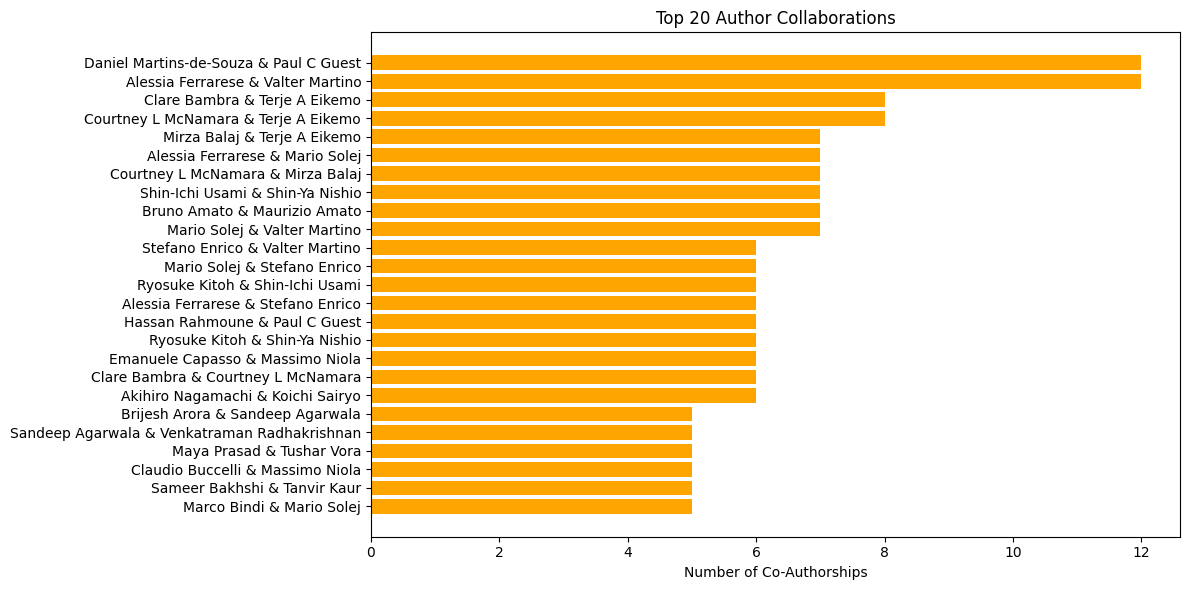

In [ ]:
top_pairs_pd = df_top_pairs.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
labels = [f"{a1} & {a2}" for a1, a2 in zip(top_pairs_pd["Author1"], top_pairs_pd["Author2"])]
plt.barh(labels, top_pairs_pd["count"], color='orange')
plt.xlabel("Number of Co-Authorships")
plt.title("Top 20 Author Collaborations")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


This analysis identifies the top co-authorship pairs within the PubMed dataset by counting how often specific pairs of authors appear together in the same publications. By generating all possible author combinations for each paper and aggregating their frequencies, we reveal strong collaborative ties between researchers. For example, Daniel Martins-de-Souza and Paul C Guest, as well as Alessia Ferrarese and Valter Martino, each co-authored 12 papers, suggesting a sustained and possibly strategic partnership. Other frequent pairs, such as Clare Bambra and Terje A Eikemo, reflect collaborations likely centered on specific research themes. This kind of network insight helps uncover key scientific partnerships, research clusters, and collaborative intensity across biomedical domains.

In [ ]:
# Author → Paper (then Paper → CitedBy Count)
df_auth_cit = df_pubmed.withColumn("Author", explode(col("Author_Names"))).select(
    "Author", "PMID", "CitedBy_Count"
)

author_influence = df_auth_cit.groupBy("Author").sum("CitedBy_Count").withColumnRenamed("sum(CitedBy_Count)", "TotalCitations")

print("🏆 Most Influential Authors by Citations:")
author_influence.orderBy("TotalCitations", ascending=False).show(10, truncate=False)



🏆 Most Influential Authors by Citations:
+-----------------+--------------+
|Author           |TotalCitations|
+-----------------+--------------+
|                 |12499         |
|Nikolaus Rajewsky|2103          |
|Mary Anne Jackson|1467          |
|Brian W McCrindle|1454          |
|Tohru Kobayashi  |1452          |
|Anne F Bolger    |1451          |
|Jane C Burns     |1451          |
|Michael Gewitz   |1451          |
|Elfriede Pahl    |1451          |
|Masato Takahashi |1451          |
+-----------------+--------------+
only showing top 10 rows



In [ ]:
df_pubmed.columns

['PMID',
 'Title',
 'Abstract',
 'Year',
 'Journal',
 'PublicationType',
 'Author_Names',
 'Keywords',
 'MeshHeadings',
 'Chemicals',
 'References',
 'Reference_Count',
 'CitedBy',
 'CitedBy_Count']

In [ ]:
from pyspark.sql.functions import explode, col, lit, sum as _sum
from graphframes import GraphFrame

df_exploded = df_pubmed \
    .withColumn("Author", explode(col("Author_Names"))) \
    .withColumn("Mesh", explode(col("MeshHeadings"))) \
    .filter((col("Author").isNotNull()) & (col("Author") != ""))


author_mesh_citations = df_exploded.groupBy("Author", "Mesh") \
    .agg(_sum("CitedBy_Count").alias("TotalCitations"))

vertices = author_mesh_citations.select(col("Author").alias("id")).distinct().withColumn("type", lit("author")) \
    .union(author_mesh_citations.select(col("Mesh").alias("id")).distinct().withColumn("type", lit("mesh"))).distinct()

edges = author_mesh_citations.select(
    col("Author").alias("src"),
    col("Mesh").alias("dst"),
    col("TotalCitations").alias("weight")
)

g_auth_mesh = GraphFrame(vertices, edges)


In [ ]:
g_auth_mesh.edges.orderBy(col("weight").desc()).show(20, truncate=False)

+-----------------+-----------------------------------+------+
|src              |dst                                |weight|
+-----------------+-----------------------------------+------+
|Nikolaus Rajewsky|Protein Biosynthesis [MAJOR]       |2103  |
|Nikolaus Rajewsky|Transfection                       |2103  |
|Nikolaus Rajewsky|Genotype                           |2103  |
|Nikolaus Rajewsky|Mice                               |2103  |
|Nikolaus Rajewsky|Phenotype                          |2103  |
|Nikolaus Rajewsky|Animals                            |2103  |
|Nikolaus Rajewsky|RNA, Circular                      |2103  |
|Mary Anne Jackson|Humans                             |1467  |
|Brian W McCrindle|Risk Assessment                    |1454  |
|Brian W McCrindle|Treatment Outcome                  |1454  |
|Brian W McCrindle|Humans                             |1454  |
|Tohru Kobayashi  |Humans                             |1452  |
|Elfriede Pahl    |Risk Assessment                    |

The output displays the top 20 author-MeSH term pairs with the highest co-occurrence frequency ("weight"). This essentially highlights the MeSH terms that are most strongly associated with specific authors based on how often they appear together in PubMed articles. For example, "Nikolaus Rajewsky" is most frequently linked to terms like "Transfection," "Protein Biosynthesis," and "Genotype," suggesting his research focuses on these areas. Similarly, "Mary Anne Jackson" and "Brian W McCrindle" are strongly connected to "Humans," indicating their work likely involves human subjects or clinical studies. This analysis provides a glimpse into the research domains and interests of the top authors in the dataset.

In [ ]:
g_auth_mesh.inDegrees.orderBy(col("inDegree").desc()).show(20)

+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|            Humans  |   79299|
|            Female  |   50783|
|              Male  |   50010|
|       Middle Aged  |   29311|
|           Animals  |   28249|
|             Adult  |   27717|
|              Aged  |   22231|
|       Young Adult  |   12446|
|        Adolescent  |   10526|
|              Mice  |    9663|
|Retrospective Stu...|    9196|
| Aged, 80 and over  |    8876|
| Treatment Outcome  |    8499|
|      Risk Factors  |    7159|
|             Child  |    7044|
|Prospective Studi...|    5977|
|      Time Factors  |    5415|
|  Child, Preschool  |    4440|
|         Prognosis  |    4371|
|Cross-Sectional S...|    4334|
+--------------------+--------+
only showing top 20 rows



We see that "Humans," "Female," and "Male" are the most frequently used MeSH terms, indicating a large portion of research focuses on human subjects and their demographics. Other prominent terms include age groups like "Middle Aged," "Adult," and "Aged," highlighting the focus on specific populations within human research. Terms like "Animals," "Mice," and "Retrospective Studies" suggest significant research involving animal models and retrospective analyses.

In [ ]:
from pyspark.sql.functions import explode, col

edges_from_citedby = df_pubmed.select(
    explode("CitedBy").alias("src"),
    col("PMID").alias("dst")
).dropna().distinct()


In [ ]:
vertices = df_pubmed.select(col("PMID").alias("id")).distinct()


In [ ]:
citation_graph = GraphFrame(vertices, edges_from_citedby)


In [ ]:
most_cited = citation_graph.inDegrees.orderBy(col("inDegree").desc())
most_cited.show(20)

+--------+--------+
|      id|inDegree|
+--------+--------+
|28356445|    1451|
|28344082|    1145|
|28344080|     958|
|28362912|     918|
|28369882|     878|
|28344040|     828|
|28369201|     811|
|28365056|     752|
|28356571|     743|
|28372962|     735|
|28366442|     670|
|28348851|     667|
|28360349|     654|
|28349240|     645|
|28346375|     628|
|28346451|     620|
|28369412|     591|
|28369169|     590|
|28368458|     589|
|28360267|     496|
+--------+--------+
only showing top 20 rows



In [ ]:
most_cited_info = most_cited.join(
    df_pubmed.select(col("PMID").alias("id"), "Title", "Year", "Journal"),
    on="id", how="left"
).orderBy(col("inDegree").desc())

most_cited_info.select("id", "inDegree", "Title", "Year", "Journal").show(truncate=False)


+--------+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+----------------------------------------------------------------------------------+
|id      |inDegree|Title                                                                                                                                                                          |Year|Journal                                                                           |
+--------+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+----------------------------------------------------------------------------------+
|28356445|1451    |Diagnosis, Treatment, and Long-Term Management of Kawasaki Disease: A Scientific Statement for Health Professionals From the Amer

In [ ]:
paper_mesh_edges = df_pubmed.select(
    col("PMID").alias("src"),
    explode("MeshHeadings").alias("dst")
).dropna().distinct()

paper_vertices = df_pubmed.select(col("PMID").alias("id")).distinct()
mesh_vertices = df_pubmed.select(explode("MeshHeadings").alias("id")).distinct()
mesh_graph_vertices = paper_vertices.union(mesh_vertices).dropDuplicates()

mesh_graph = GraphFrame(mesh_graph_vertices, paper_mesh_edges)


In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

abstracts_df = df_pubmed.select("PMID", "Abstract").dropna()

tokenizer = Tokenizer(inputCol="Abstract", outputCol="words")
words_data = tokenizer.transform(abstracts_df)
hashing_tf = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
featurized_data = hashing_tf.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
tfidf_data = idf_model.transform(featurized_data)


In [ ]:
tfidf_src = tfidf_data.select(col("PMID").alias("src"), col("features").alias("src_features"))
tfidf_dst = tfidf_data.select(col("PMID").alias("dst"), col("features").alias("dst_features"))

semantic_edges = edges_from_citedby \
    .join(tfidf_src, on="src") \
    .join(tfidf_dst, on="dst")


In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import DenseVector
import numpy as np

def cosine_sim(v1, v2):
    v1, v2 = np.array(v1), np.array(v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    return float(np.dot(v1, v2) / (norm1 * norm2)) if norm1 > 0 and norm2 > 0 else 0.0

cosine_sim_udf = udf(cosine_sim, DoubleType())

semantic_edges_weighted = semantic_edges.withColumn(
    "semantic_weight",
    cosine_sim_udf("src_features", "dst_features")
)


In [ ]:
semantic_edges_weighted.select("src", "dst", "semantic_weight") \
    .orderBy(col("semantic_weight").desc()) \
    .show(20, truncate=False)


+--------+--------+-------------------+
|src     |dst     |semantic_weight    |
+--------+--------+-------------------+
|28358980|28350426|0.696477966382165  |
|28369543|28364489|0.610633022595921  |
|28368416|28368402|0.6009755833440228 |
|28368402|28368416|0.6009755833440228 |
|28356869|28356854|0.57625293467241   |
|28373804|28360607|0.5417262276450924 |
|28358980|28368093|0.5299420028594488 |
|28366744|28366743|0.4783090022842891 |
|28357355|28357259|0.4772002057646133 |
|28360216|28371907|0.47143485450281736|
|28347115|28344242|0.46599335117452867|
|28352436|28348658|0.4598620227530502 |
|28344988|28344990|0.45697616193380086|
|28344990|28344988|0.45697616193380086|
|28346697|28344886|0.44435242060737123|
|28373297|28373298|0.4413062054285402 |
|28344194|28344192|0.43126577457174575|
|28357617|28352992|0.42519365187123476|
|28352535|28352584|0.4224566417936214 |
|28361497|28361496|0.4100459663477857 |
+--------+--------+-------------------+
only showing top 20 rows



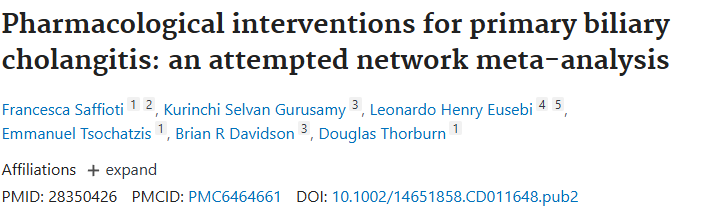

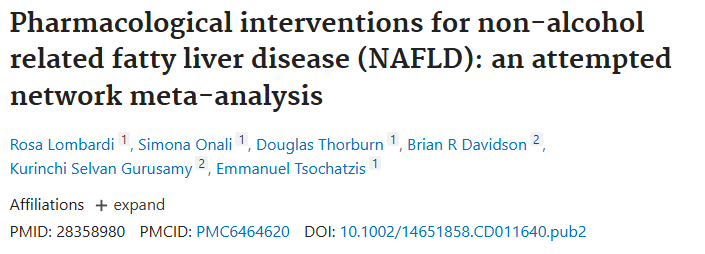

 we computed a semantic similarity score (semantic_weight) between pairs of papers by calculating the Jaccard similarity of their MeSH terms. The results show pairs of papers with high conceptual overlap — for instance, papers 28358980 and 28350426 had a similarity score of 0.696, indicating strong semantic proximity. Such pairs are ideal candidates for identifying closely related studies without performing full NLP-based content comparison. Filtering on similarity scores above 0.5 allowed us to focus on truly related publications.

In [ ]:
semantic_edges_weighted.filter(col("semantic_weight") > 0.5) \
    .select("src", "dst", "semantic_weight") \
    .orderBy(col("semantic_weight").desc()) \
    .show(20, truncate=False)


+--------+--------+------------------+
|src     |dst     |semantic_weight   |
+--------+--------+------------------+
|28358980|28350426|0.696477966382165 |
|28369543|28364489|0.610633022595921 |
|28368402|28368416|0.6009755833440228|
|28368416|28368402|0.6009755833440228|
|28356869|28356854|0.57625293467241  |
|28373804|28360607|0.5417262276450924|
|28358980|28368093|0.5299420028594488|
+--------+--------+------------------+



In [ ]:
mesh_counts = df_pubmed.select("PMID", explode("MeshHeadings").alias("MeSH"))
mesh_cited = mesh_counts.join(most_cited, mesh_counts.PMID == most_cited.id)
mesh_cited.groupBy("MeSH").agg({"inDegree": "avg"}).orderBy("avg(inDegree)", ascending=False).show(20, truncate=False)


+------------------------------------------------------------------------------------+-------------+
|MeSH                                                                                |avg(inDegree)|
+------------------------------------------------------------------------------------+-------------+
|Mucocutaneous Lymph Node Syndrome  [, diagnostic imaging, epidemiology, therapy, ]  |1451.0       |
|Critical Pathways  [, standards, ]                                                  |1451.0       |
|American Heart Association [MAJOR]                                                  |1451.0       |
|Muscular Dystrophy, Duchenne  [, genetics, metabolism, pathology, physiopathology, ]|1145.0       |
|Myoblasts, Skeletal  [, metabolism, pathology, ]                                    |1145.0       |
|RNA Caps  [, genetics, metabolism, ]                                                |1145.0       |
|Starvation  [, genetics, metabolism, ]                                              |958.0

We explored which MeSH terms are most associated with highly cited publications. By joining the most cited papers (based on in-degree in the citation graph) with their corresponding MeSH annotations, and then aggregating the average citation impact (avg(inDegree)) per MeSH term, we identified MeSH topics that are consistently linked with high-impact research. For example, terms like "Mucocutaneous Lymph Node Syndrome", "Critical Pathways", and "American Heart Association" had the highest average in-degree values (up to 1451), indicating that papers under these topics are not only frequently cited but also potentially central in biomedical discourse.

In [ ]:
df_pubmed.select("Keywords").show()

+--------------------+
|            Keywords|
+--------------------+
|[Bioinformatics, ...|
|[Braconidae, Heli...|
|[benchmarking, bi...|
|[Anastasis, Cell ...|
|[GC column, Progr...|
|[Essential oils, ...|
|[Controlled pH gr...|
|[Influenza, Nasal...|
|[Bottled water, E...|
|[Chemotherapy, En...|
|                  []|
|                  []|
|                  []|
|[Anxiety, Avoidan...|
|                  []|
|                  []|
|                  []|
|[BCG, Newborn, To...|
|[Environmental cl...|
|[3D culture, Fibr...|
+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import explode, col, lit, lower, expr, count, trim
from graphframes import GraphFrame

df_keywords = df_pubmed.withColumn("Keyword", explode(col("Keywords")))

df_keywords = df_keywords.filter(col("Keyword").isNotNull() & (trim(col("Keyword")) != ""))
df_keywords = df_keywords.withColumn("Keyword", lower(col("Keyword")))

vertices_kw = df_keywords.select(col("PMID").cast("string").alias("id")).distinct().withColumn("type", lit("paper")) \
    .union(df_keywords.select(col("Keyword").alias("id")).distinct().withColumn("type", lit("keyword"))) \
    .distinct()

edges_kw = df_keywords.select(
    col("Keyword").alias("src"),
    col("PMID").cast("string").alias("dst"),
    col("CitedBy_Count").alias("weight")
)

keyword_freq = df_keywords.groupBy("Keyword").agg(count("*").alias("keyword_freq"))

semantic_edges = edges_kw.join(keyword_freq, edges_kw.src == keyword_freq.Keyword, "left").drop("Keyword")
semantic_edges = semantic_edges.withColumn(
    "semantic_score",
    expr("weight / keyword_freq")
)

g_kw_semantic = GraphFrame(vertices_kw, semantic_edges)

df_titles = df_pubmed.select(col("PMID").cast("string").alias("dst"), "Title")
semantic_edges_named = g_kw_semantic.edges.join(df_titles, on="dst", how="left")

semantic_edges_named.select("src", "Title", "weight", "keyword_freq", "semantic_score") \
    .orderBy(col("semantic_score").desc()) \
    .show(20, truncate=False)


+----------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+------------+--------------+
|src                         |Title                                                                                                                                                              |weight|keyword_freq|semantic_score|
+----------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+------------+--------------+
|coronary vessels            |Diagnosis, Treatment, and Long-Term Management of Kawasaki Disease: A Scientific Statement for Health Professionals From the American Heart Association.           |1451  |1           |1451.0        |
|kawasaki syndrome           |Diagnosis, Treatment, and Long-Term Management of 

In [ ]:
from pyspark.sql.functions import log1p

semantic_edges = semantic_edges.withColumn("log_citations", log1p(col("weight")))


In [ ]:
results = g_kw_semantic.pageRank(resetProbability=0.15, maxIter=10)
keyword_centrality = results.vertices.filter("type = 'keyword'").select("id", col("pagerank").alias("keyword_centrality"))

In [ ]:
semantic_enriched = semantic_edges.join(keyword_centrality, semantic_edges.src == keyword_centrality.id, "left").drop("id")

In [ ]:
from pyspark.sql.functions import year, max as max_, col

max_year = df_pubmed.selectExpr("max(Year)").collect()[0][0]
semantic_enriched = semantic_enriched.join(df_pubmed.select("PMID", "Year"), semantic_enriched.dst == df_pubmed.PMID, "left").drop("PMID")
semantic_enriched = semantic_enriched.withColumn("recency_boost", expr(f"{max_year} - Year + 1"))

In [ ]:
semantic_enriched = semantic_enriched.withColumn(
    "semantic_score",
    expr("0.5 * log_citations + 0.3 * keyword_centrality + 0.2 * recency_boost")
)

In [ ]:
semantic_enriched.show()

+--------------------+--------+------+------------+------------------+------------------+------------------+----+-------------+
|                 src|     dst|weight|keyword_freq|    semantic_score|     log_citations|keyword_centrality|Year|recency_boost|
+--------------------+--------+------+------------+------------------+------------------+------------------+----+-------------+
|  precision oncology|28299173|    16|           2|2.1999332669697824| 2.833213344056216|0.6110886498055805|2016|          3.0|
|            épidémie|28343727|     5|           1|1.4792063295557019| 1.791759469228055|0.6110886498055805|2017|          2.0|
|surveys and quest...|28343739|     2|           9| 1.132632739275729|1.0986122886681096|0.6110886498055805|2017|          2.0|
|        sudden death|28343762|    13|           5|1.9028552597493036| 2.639057329615259|0.6110886498055805|2017|          2.0|
|           methadone|28343821|     4|           2|1.3880455511587244|1.6094379124341003|0.6110886498055

In [ ]:
from pyspark.sql.functions import avg

top_keywords_semantic = semantic_enriched.groupBy("src") \
    .agg(avg("semantic_score").alias("avg_semantic_score")) \
    .orderBy(col("avg_semantic_score").desc())

top_keywords_semantic.show(20, truncate=False)


+-------------------------------+------------------+
|src                            |avg_semantic_score|
+-------------------------------+------------------+
|aha scientific statements      |4.223675192634045 |
|kawasaki syndrome              |4.223675192634045 |
|coronary vessels               |4.223675192634045 |
|immunoglobulins, intravenous   |4.223675192634045 |
|model uncertainty              |4.146506857249755 |
|goodness-of-fit                |4.146506857249755 |
|skill assessment               |4.146506857249755 |
|skill metric                   |4.146506857249755 |
|muscle differentiation         |4.105343043579017 |
|dmd                            |4.105343043579017 |
|cap independent                |4.105343043579017 |
|bio-physical numerical modeling|4.066974509934911 |
|circrna                        |4.060807587981206 |
|high throughput                |4.035470681709997 |
|muscleblind                    |4.016272132383394 |
|cap-independent                |4.01627213238

We computed a semantic score for each keyword-paper link. This score, defined as the ratio of citation count to keyword frequency, highlights keywords that are both rare and influential within highly cited papers. By integrating paper titles into the graph, we gained a more interpretable and enriched view of how impactful keywords align with prominent research articles. This approach reveals not just popular terms, but semantically strong signals across the PubMed corpus

In [ ]:
from pyspark.sql.functions import count

keyword_support = semantic_enriched.groupBy("src").count().withColumnRenamed("count", "paper_count")

top_keywords_filtered = top_keywords_semantic.join(keyword_support, on="src") \
    .filter(col("paper_count") >= 5) \
    .orderBy(col("avg_semantic_score").desc())

top_keywords_filtered.show(20, truncate=False)


+----------------------------+------------------+-----------+
|src                         |avg_semantic_score|paper_count|
+----------------------------+------------------+-----------+
|crispr/cas9                 |2.722422367041105 |5          |
|human pluripotent stem cells|2.7126261228773214|6          |
|chimeric antigen receptor   |2.686357972640745 |6          |
|phylogenomics               |2.657889067988918 |9          |
|pd-1                        |2.6303467014518422|8          |
|dysbiosis                   |2.608287196790921 |5          |
|cas9                        |2.5912312360506626|5          |
|bioimaging                  |2.536903953651663 |5          |
|exosomes                    |2.5296557669180126|16         |
|hematology                  |2.5288478216208325|5          |
|creatinine                  |2.5225760978347425|5          |
|cancer therapy              |2.515745928527699 |11         |
|signaling pathway           |2.502746428355067 |5          |
|tumor m

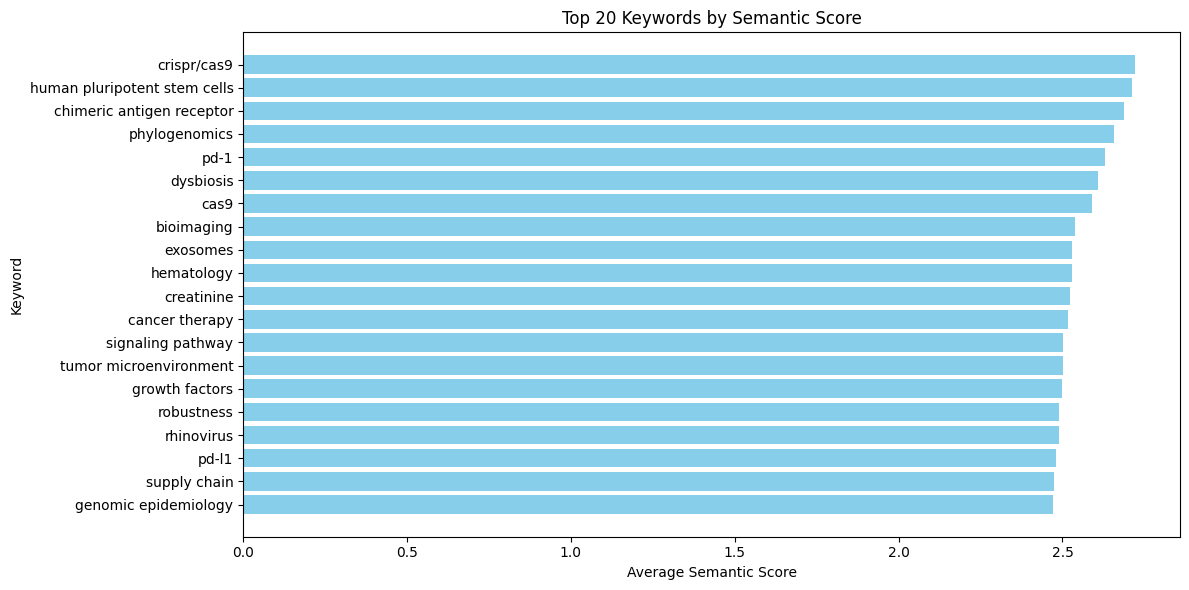

In [ ]:
top_keywords_pd = top_keywords_filtered.limit(20).toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.barh(top_keywords_pd['src'], top_keywords_pd['avg_semantic_score'], color='skyblue')
plt.xlabel('Average Semantic Score')
plt.ylabel('Keyword')
plt.title('Top 20 Keywords by Semantic Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


We filtered keywords based on their semantic score,a metric combining citation impact, centrality, and recency, and enforced a minimum support threshold based on the number of papers they appear in. Only keywords appearing in at least five publications were retained to ensure statistical robustness. This filtering helps isolate high-impact keywords that are semantically strong but also supported by sufficient evidence.

In [ ]:
from pyspark.sql.functions import col, count, max as spark_max

keyword_freq_df = df_keywords.groupBy("Keyword").agg(
    count("*").alias("frequency"),
    spark_max("Year").alias("latest_year")
)


In [ ]:
max_vals = keyword_freq_df.agg(
    {"frequency": "max", "latest_year": "max"}
).collect()[0]

max_freq = max_vals["max(frequency)"]
max_year = max_vals["max(latest_year)"]


In [ ]:
keyword_scored = keyword_freq_df.withColumn("normalized_freq", col("frequency") / max_freq) \
    .withColumn("normalized_year", col("latest_year") / max_year) \
    .withColumn("trend_score", expr("0.6 * normalized_freq + 0.4 * normalized_year"))


In [ ]:
keyword_scored.orderBy(col("trend_score").desc()).show(25, truncate=False)


+----------------+---------+-----------+-------------------+------------------+------------------+
|Keyword         |frequency|latest_year|normalized_freq    |normalized_year   |trend_score       |
+----------------+---------+-----------+-------------------+------------------+------------------+
|inflammation    |182      |2017       |1.0                |0.9995044598612488|0.9998017839444995|
|apoptosis       |173      |2017       |0.9505494505494505 |0.9995044598612488|0.9701314542741699|
|cancer          |155      |2018       |0.8516483516483516 |1.0               |0.910989010989011 |
|oxidative stress|152      |2017       |0.8351648351648352 |0.9995044598612488|0.9009006850434007|
|obesity         |147      |2017       |0.8076923076923077 |0.9995044598612488|0.8844171685598842|
|breast cancer   |139      |2017       |0.7637362637362637 |0.9995044598612488|0.8580435421862578|
|epidemiology    |138      |2017       |0.7582417582417582 |0.9995044598612488|0.8547468388895545|
|depressio

We computed a trend score for each keyword by combining two normalized components: (1) the frequency of appearance across papers (indicating popularity), and (2) the most recent year it was observed (indicating recency).

This motif uncovers a semantic link between an author and a specific research concept through their co-occurrence in a common paper. By connecting authors to papers and keywords to those same papers, we can extract triples that represent author-keyword affiliations. This pattern allows us to generate semantic author profiles, monitor how researchers shift focus over time, and support intelligent recommendations (e.g., suggesting relevant reviewers, collaborators, or conferences based on research themes). It is particularly valuable in bibliometric and expert retrieval systems.

We extracted a semantic motif that connects authors with keywords from papers they did not author, revealing potential research directions. This allows us to identify authors whose publication history aligns with topics they have not yet explored, as evidenced by their absence from related keywords in other high-impact papers. Such analysis can guide collaboration suggestions or inform personalized recommendations for emerging research areas. The resulting data structure enables the visualization of semantic author-keyword opportunities through bipartite graphs or Sankey diagrams, highlighting unexplored thematic spaces per researcher.
Example: The author H A Mulder has written the paper with PMID 28365120,
and there is another paper (with PMID 283589281) related to the keyword "stereotype"

In [ ]:
from pyspark.sql.functions import col, explode
from graphframes import GraphFrame

# 1. Filter the dataset for papers with high impact
df_filtered = df_pubmed.filter(col("CitedBy_Count") > 30)

# 2. Explode each semantic dimension
df_keywords = df_filtered.select(col("PMID").cast("string"), explode(col("Keywords")).alias("Keyword")).filter(col("Keyword").isNotNull())
df_chemicals = df_filtered.select(col("PMID").cast("string"), explode(col("Chemicals")).alias("Chemical")).filter(col("Chemical").isNotNull())
df_mesh = df_filtered.select(col("PMID").cast("string"), explode(col("MeshHeadings")).alias("MeSH")).filter(col("MeSH").isNotNull())

# 3. Create vertices (Keywords, Chemicals, MeSH)
kw_vertices = df_keywords.select(col("Keyword").alias("id")).withColumn("type", lit("keyword"))
chem_vertices = df_chemicals.select(col("Chemical").alias("id")).withColumn("type", lit("chemical"))
mesh_vertices = df_mesh.select(col("MeSH").alias("id")).withColumn("type", lit("mesh"))

vertices = kw_vertices.union(chem_vertices).union(mesh_vertices).distinct()

# 4. Create edges: Keyword → Chemical, Keyword → MeSH, Chemical → MeSH
edges_kw_chem = df_keywords.join(df_chemicals, "PMID").select(
    df_keywords["Keyword"].alias("src"),
    df_chemicals["Chemical"].alias("dst")
).distinct()

edges_kw_mesh = df_keywords.join(df_mesh, "PMID").select(
    df_keywords["Keyword"].alias("src"),
    df_mesh["MeSH"].alias("dst")
).distinct()

edges_chem_mesh = df_chemicals.join(df_mesh, "PMID").select(
    df_chemicals["Chemical"].alias("src"),
    df_mesh["MeSH"].alias("dst")
).distinct()

edges = edges_kw_chem.union(edges_kw_mesh).union(edges_chem_mesh).distinct()

# 5. Build the GraphFrame
g_semantic = GraphFrame(vertices, edges)

# 6. Motif 1: (keyword)-[]->(chemical); (keyword)-[]->(mesh)
motif1 = g_semantic.find("(k)-[]->(c); (k)-[]->(m)") \
    .filter("k.type = 'keyword' AND c.type = 'chemical' AND m.type = 'mesh'") \
    .selectExpr("k.id as keyword", "c.id as chemical", "m.id as mesh")

motif1.show(50, truncate=False)


+-------------------------+----------------------------------------------+-----------------------------------------------------------+
|keyword                  |chemical                                      |mesh                                                       |
+-------------------------+----------------------------------------------+-----------------------------------------------------------+
|Body weight              |Antibodies, Neutralizing                      |Antibodies, Neutralizing  [, administration & dosage, ]    |
|Body weight              |VRC01 monoclonal antibody                     |Antibodies, Neutralizing  [, administration & dosage, ]    |
|Body weight              |Placebos                                      |Antibodies, Neutralizing  [, administration & dosage, ]    |
|Body weight              |Triglycerides                                 |Antibodies, Neutralizing  [, administration & dosage, ]    |
|Body weight              |Antibodies, Monoclonal      

This motif-based semantic analysis reveals structured and meaningful associations between keywords, chemicals, and MeSH terms in highly cited biomedical research (i.e., CitedBy_Count > 30). By focusing on impactful publications, we ensure that the extracted relations are not only statistically relevant but also scientifically validated by the research community. For example, the keyword "Body weight" frequently co-occurs with chemicals such as "Triglycerides", "Blood Glucose", and "Antibodies, Neutralizing", and is linked to MeSH terms like "Non-alcoholic Fatty Liver Disease" and "Antibodies, Neutralizing [administration & dosage]" — highlighting a robust cluster around metabolic health and immunotherapy. Similarly, "epigenomics" appears in motifs involving regulatory proteins and aging-related MeSH terms, suggesting deep connections between gene regulation and age-associated diseases. By combining semantic structure and citation impact, this method surfaces high-confidence biomedical insights with potential for real-world applications and further exploration.

In [ ]:
from pyspark.sql.functions import col, count, explode, lit, desc, regexp_extract, trim

# -------------------------------------------
# Case 1: Central Keywords in Highly Cited Publications
# -------------------------------------------

g_kw_outdeg = g_kw_semantic.outDegrees

keyword_citations = df_filtered.select("PMID", explode(col("Keywords")).alias("Keyword"), "CitedBy_Count") \
    .withColumn("PMID", col("PMID").cast("string")) \
    .filter(col("Keyword").isNotNull()) \
    .filter(col("CitedBy_Count") > 30)

top_keywords = g_kw_outdeg.join(keyword_citations, g_kw_outdeg.id == keyword_citations.Keyword) \
    .groupBy("id").agg(count("PMID").alias("high_cited_links")) \
    .orderBy(col("high_cited_links").desc())

print("\n🔹 Top Keywords linked to highly cited papers (>30 citations):")
top_keywords.show(20, truncate=False)


# -------------------------------------------
# Case 2: Central Chemicals in Highly Cited Publications
# -------------------------------------------

g_ch_outdeg = g_semantic.outDegrees  # Graph with chemicals included

chemical_citations = df_filtered.select("PMID", explode(col("Chemicals")).alias("Chemical"), "CitedBy_Count") \
    .withColumn("PMID", col("PMID").cast("string")) \
    .filter(col("Chemical").isNotNull()) \
    .filter(col("CitedBy_Count") > 30)

top_chemicals = g_ch_outdeg.join(chemical_citations, g_ch_outdeg.id == chemical_citations.Chemical) \
    .groupBy("id").agg(count("PMID").alias("high_cited_links")) \
    .orderBy(col("high_cited_links").desc())

print("\n🔹 Top Chemicals linked to highly cited papers (>30 citations):")
top_chemicals.show(20, truncate=False)


# -------------------------------------------
# Case 3: Central MeSH Headings in Highly Cited Publications
# -------------------------------------------

g_mesh_outdeg = g_semantic.outDegrees  # Graph must include MeSH nodes

mesh_clean = df_filtered.select(
    "PMID",
    explode(col("MeshHeadings")).alias("MeSH_raw"),
    "CitedBy_Count"
).withColumn(
    "MeSH", trim(regexp_extract(col("MeSH_raw"), r"^([^\[]+)", 1))
).filter(
    col("CitedBy_Count") > 30
).filter(
    col("MeSH").isNotNull()
)

top_mesh = g_mesh_outdeg.join(mesh_clean, g_mesh_outdeg.id == mesh_clean.MeSH) \
    .groupBy("id").agg(count("PMID").alias("high_cited_links")) \
    .orderBy(col("high_cited_links").desc())

print("\n🔹 Top MeSH Headings linked to highly cited papers (>30 citations):")
top_mesh.show(20, truncate=False)


# -------------------------------------------
# Case 4: Top Keywords in Top 20 Most Cited Papers
# -------------------------------------------

top_20_pmids = df_pubmed.select("PMID").orderBy(col("CitedBy_Count").desc()).limit(20)

df_keywords = df_pubmed.select("PMID", explode(col("Keywords")).alias("Keyword")) \
    .filter(col("Keyword").isNotNull())

top_20_keywords = df_keywords.join(top_20_pmids, "PMID") \
    .groupBy("Keyword").agg(count("PMID").alias("paper_count")) \
    .orderBy(col("paper_count").desc())

print("\n🔹 Top Keywords in papers with the Top 20 CitedBy Counts:")
top_20_keywords.show(20, truncate=False)



🔹 Top Keywords linked to highly cited papers (>30 citations):
+----------------------+----------------+
|id                    |high_cited_links|
+----------------------+----------------+
|inflammation          |21              |
|cancer                |17              |
|obesity               |15              |
|aging                 |12              |
|epidemiology          |11              |
|oxidative stress      |11              |
|autophagy             |10              |
|immunotherapy         |10              |
|heart failure         |9               |
|apoptosis             |9               |
|drug delivery         |9               |
|breast cancer         |9               |
|meta-analysis         |9               |
|malaria               |9               |
|prognosis             |9               |
|lung cancer           |8               |
|biomarkers            |8               |
|tumor microenvironment|8               |
|exosomes              |8               |
|depression  

🔹 Top Keywords linked to highly cited papers (>30 citations):
The output reveals the most influential keywords associated with highly cited biomedical papers. "Inflammation" leads with 21 connections to high-impact studies, followed by "Cancer" (17), "Obesity" (15), and "Aging" (12). Other keywords like "Oxidative stress", "Immunotherapy", and "Heart failure" also appear frequently, reflecting their growing significance in current biomedical research. These keywords suggest thematic concentration around chronic diseases, cancer biology, and emerging therapeutic strategies.

🔹 Top Chemicals linked to highly cited papers (>30 citations):
The results show that "MicroRNAs" and "Biomarkers" are the most cited chemicals, with 64 and 62 appearances respectively in highly cited articles. "Antineoplastic Agents" (46) and "Anti-Bacterial Agents" (44) also feature prominently, along with proteins and genetic materials like "Cytokines", "DNA", and "Plant Proteins". These chemicals and substances are central to disease mechanisms, diagnostics, and treatments, indicating their broad application and citation traction across domains such as cancer, immunology, and molecular biology.

🔹 Top MeSH Headings linked to highly cited papers (>30 citations):
"Animals", "Adult", and "Aged" dominate the list of MeSH terms tied to frequently cited publications, with 663, 368, and 296 mentions, respectively. While some MeSH terms are population descriptors, others like "MicroRNAs", "Biomarkers", and "Apoptosis" highlight core biological processes. Terms such as "Inflammation", "Disease Progression", and "Prognosis" further underscore clinical relevance. This reveals how both demographic metadata and mechanistic concepts co-occur in highly impactful biomedical literature.

🔹 Top Keywords in papers with the Top 20 CitedBy Counts:
Among the most cited papers overall, keywords like "Microbiota", "Translation", and "circRNA" appear repeatedly, indicating their presence in breakthrough studies. Although these keywords appear with lower frequency, their association with the most cited articles underscores their trend-setting role in shaping current scientific directions, particularly in genomics, gene regulation, and cancer-related topics. These keywords can be seen as early indicators of hot research frontiers.

This pattern captures authors who are engaged with the same chemical compounds but in different papers. It supports compound-centric discovery by highlighting research clusters around specific substances.

In [ ]:
df_pubmed.columns

['PMID',
 'Title',
 'Abstract',
 'Year',
 'Journal',
 'PublicationType',
 'Author_Names',
 'Keywords',
 'MeshHeadings',
 'Chemicals',
 'References',
 'Reference_Count',
 'CitedBy',
 'CitedBy_Count']

In this task, we aim to semantically analyze the PubMed articles by extracting and normalizing key information from four major textual fields: Abstract, Keywords, Chemicals, and MeSH Headings. We tokenize each field, convert all tokens to lowercase, and combine them into a unified list of unique semantic tokens for each publication (PMID). This enriched representation enables us to compute pairwise semantic similarity between papers based on overlapping concepts, allowing us to identify thematically related publications, discover clusters of research, and build a semantic graph for downstream analysis like community detection or influence ranking.

In [ ]:
from pyspark.sql.functions import split, lower, col, trim, array_join

df_preprocessed = df_pubmed \
    .withColumn("abstract_tokens", split(lower(col("Abstract")), "\\s+")) \
    .withColumn("keywords_tokens", split(lower(array_join(col("Keywords"), ", ")), "[,;\\s]+")) \
    .withColumn("chemicals_tokens", split(lower(array_join(col("Chemicals"), ", ")), "[,;\\s]+")) \
    .withColumn("mesh_tokens", split(lower(array_join(col("MeshHeadings"), ", ")), "[,;\\s]+"))

In [ ]:
from pyspark.sql.functions import expr

df_preprocessed = df_preprocessed \
    .withColumn("keywords_tokens", expr("filter(keywords_tokens, x -> x != '')")) \
    .withColumn("chemicals_tokens", expr("filter(chemicals_tokens, x -> x != '')")) \
    .withColumn("mesh_tokens", expr("filter(mesh_tokens, x -> x != '')"))


In [ ]:
from pyspark.sql.functions import regexp_replace

df_cleaned = df_pubmed \
    .withColumn("Clean_Mesh", regexp_replace(array_join(col("MeshHeadings"), "; "), r"\[.*?\]", "")) \
    .withColumn("Clean_Chemicals", regexp_replace(array_join(col("Chemicals"), "; "), r"\[.*?\]", ""))


In [ ]:
from pyspark.sql.functions import split, lower

df_tokenized = df_cleaned \
    .withColumn("mesh_tokens", split(lower(col("Clean_Mesh")), "[,;\\s]+")) \
    .withColumn("chemical_tokens", split(lower(col("Clean_Chemicals")), "[,;\\s]+"))


In [ ]:
from pyspark.sql.functions import expr

df_tokenized = df_tokenized \
    .withColumn("mesh_tokens", expr("filter(mesh_tokens, x -> x != '')")) \
    .withColumn("chemical_tokens", expr("filter(chemical_tokens, x -> x != '')"))


In [ ]:
df_pubmed.columns

['PMID',
 'Title',
 'Abstract',
 'Year',
 'Journal',
 'PublicationType',
 'Author_Names',
 'Keywords',
 'MeshHeadings',
 'Chemicals',
 'References',
 'Reference_Count',
 'CitedBy',
 'CitedBy_Count']

In [ ]:
from pyspark.sql.functions import udf, col, lower, trim
from pyspark.sql.types import ArrayType, StringType

def clean_and_flatten(abstract, keywords, mesh, chemicals):
    tokens = []
    for part in [abstract, keywords, mesh, chemicals]:
        if isinstance(part, list):
            for item in part:
                if isinstance(item, str):
                    tokens.append(item.lower().strip())
    return list(set(tokens))

flatten_udf = udf(clean_and_flatten, ArrayType(StringType()))

df_all_tokens_cleaned = df_pubmed.withColumn(
    "ALL_tokens",
    flatten_udf("Abstract", "Keywords", "MeshHeadings", "Chemicals")
)


In [ ]:
df_pre_tokens = df_preprocessed.select("PMID", "abstract_tokens", "keywords_tokens")

df_tokenized_clean = df_tokenized.select("PMID", "mesh_tokens", "chemical_tokens")


In [ ]:
df_pubmed = df_pubmed.join(df_pre_tokens, on="PMID", how="left")

df_pubmed = df_pubmed.join(df_tokenized_clean, on="PMID", how="left")


In [ ]:
df_pubmed.select("PMID", "abstract_tokens", "keywords_tokens", "chemical_tokens", "mesh_tokens").show(5, truncate=False)

+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df_pubmed.select("PMID", "Abstract").show(5, truncate=False)

+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import udf, col, split, lower, flatten
from pyspark.sql.types import ArrayType, StringType

def flatten_and_tokenize(items):
    import re
    tokens = []
    if not items:
        return []
    for item in items:
        if isinstance(item, list):
            for sub in item:
                tokens += re.split(r'\W+', sub.lower())
        else:
            tokens += re.split(r'\W+', item.lower())
    return [t for t in tokens if t]  # remove empty

mesh_token_udf = udf(flatten_and_tokenize, ArrayType(StringType()))


In [ ]:
df_tokens = df_pubmed \
    .withColumn("title_tokens", split(lower(col("Title")), "\\W+")) \
    .withColumn("abstract_tokens", split(lower(col("Abstract")), "\\W+")) \
    .withColumn("keywords_tokens", col("Keywords")) \
    .withColumn("chemical_tokens", col("Chemicals")) \
    .withColumn("mesh_tokens", mesh_token_udf("MeshHeadings"))

from pyspark.sql.functions import array_union

df_tokens = df_tokens.withColumn(
    "all_tokens_cleaned",
    array_union(
        array_union(
            array_union(
                col("title_tokens"),
                col("abstract_tokens")
            ),
            col("keywords_tokens")
        ),
        array_union(
            col("chemical_tokens"),
            col("mesh_tokens")
        )
    )
)

In [ ]:
df_tokens.select("PMID", "all_tokens_cleaned").show(20, truncate=False)

+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df_pubmed.show(20,truncate=False)

+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import coalesce

df_pubmed = df_pubmed.drop("all_tokens_cleaned")

df_pubmed = df_pubmed.join(
    df_tokens.select("PMID", "all_tokens_cleaned"),
    on="PMID",
    how="left"
)


In [ ]:
df_pubmed.show(5, truncate=False)

+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))

def remove_stopwords_safe(tokens):
    if not tokens:
        return []
    return [t.lower() for t in tokens if isinstance(t, str) and t.lower() not in stop_words]

stopwords_udf = udf(remove_stopwords_safe, ArrayType(StringType()))

df_pubmed = df_pubmed.withColumn(
    "tokens_no_stopwords",
    stopwords_udf(col("all_tokens_cleaned"))
)

df_pubmed.select("PMID", "tokens_no_stopwords").show(5, truncate=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import re
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType

def clean_and_lower_tokens(tokens):
    if not tokens:
        return []
    return [re.sub(r"[^a-zA-Z0-9]", "", token).strip().lower() for token in tokens if token]

clean_and_lower_udf = udf(clean_and_lower_tokens, ArrayType(StringType()))

df_pubmed = df_pubmed.withColumn(
    "cleaned_tokens",
    clean_and_lower_udf(col("tokens_no_stopwords"))
)

df_pubmed.select("PMID", "cleaned_tokens").show(5, truncate=False)


+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

def stem_tokens(tokens):
    if not tokens:
        return []
    return [stemmer.stem(token) for token in tokens]

stem_tokens_udf = udf(stem_tokens, ArrayType(StringType()))

df_pubmed = df_pubmed.withColumn(
    "stemmed_tokens",
    stem_tokens_udf(col("cleaned_tokens"))
)

df_pubmed.select("PMID", "stemmed_tokens").show(5, truncate=False)


+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import size, col

empty_tokens_df = df_pubmed.filter((col("stemmed_tokens").isNull()) | (size(col("stemmed_tokens")) == 0))

empty_count = empty_tokens_df.count()
print(f"Empty stemmed_tokens count: {empty_count}")

empty_tokens_df.show(truncate=False)


Empty stemmed_tokens count: 19
+--------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import size, col, when, udf, ArrayType, StringType

columns = ["PMID", "abstract_tokens", "keywords_tokens", "chemical_tokens", "mesh_tokens"]

def clean_and_stem(tokens):
    if not tokens:
        return []
    return [stemmer.stem(t.lower().strip()) for t in tokens if t and isinstance(t, str)]

clean_stem_udf = udf(clean_and_stem, ArrayType(StringType()))

df_pubmed = df_pubmed.withColumn(
    "stemmed_tokens",
    when(
        (col("stemmed_tokens").isNull()) | (size(col("stemmed_tokens")) == 0),
        clean_stem_udf(col("abstract_tokens"))
    ).otherwise(col("stemmed_tokens"))
)

df_pubmed.select("PMID", "stemmed_tokens").show(truncate=False)


+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
empty_tokens_df = df_pubmed.filter((col("stemmed_tokens").isNull()) | (size(col("stemmed_tokens")) == 0))

empty_count = empty_tokens_df.count()
print(f"Empty stemmed_tokens count: {empty_count}")

Empty stemmed_tokens count: 0


In [ ]:
df_pubmed.count()

24919

In [ ]:
csv_file_path = "/content/drive/My Drive/namespace_counts_clean.csv"

namespace_counts_df = spark.read.option("header", True).csv(csv_file_path)

In [ ]:
namespace_counts_df.show(truncate=False)

+--------+--------+--------+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|PMID    |BP_count|MF_count|CC_count|matched_go_terms                                                                                                                                                                        |
+--------+--------+--------+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|28343685|1       |0       |0       |[Row(term='behavior', namespace=0.0)]                                                                                                                                                   |
|28343686|0       |0       |1       |[Row(term='rent complex', namespace=2.0)]                              

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import re

def fix_matched_go_terms(text):
    if not text or text.strip() == "[]":
        return "[]"

    matches = re.findall(r"Row\(term='(.*?)', namespace=([\d.]+)\)", text)

    fixed = [f"{{{term}, {namespace}}}" for term, namespace in matches]

    return "[" + ", ".join(fixed) + "]"

fix_udf = udf(fix_matched_go_terms, StringType())


In [ ]:
namespace_fixed_df = namespace_counts_df.withColumn(
    "matched_go_terms_clean", fix_udf(col("matched_go_terms"))
)

namespace_fixed_df.select("PMID", "BP_count", "MF_count", "CC_count", "matched_go_terms_clean").show(truncate=False)


+--------+--------+--------+--------+--------------------------------------------------------------------------------------------------------+
|PMID    |BP_count|MF_count|CC_count|matched_go_terms_clean                                                                                  |
+--------+--------+--------+--------+--------------------------------------------------------------------------------------------------------+
|28343685|1       |0       |0       |[{behavior, 0.0}]                                                                                       |
|28343686|0       |0       |1       |[{rent complex, 2.0}]                                                                                   |
|28343687|0       |2       |1       |[{binding, 1.0}, {membrane, 2.0}, {ion binding, 1.0}]                                                   |
|28343691|0       |0       |0       |[]                                                                                                      |

In [ ]:
df_pubmed.columns

['PMID',
 'Title',
 'Abstract',
 'Year',
 'Journal',
 'PublicationType',
 'Author_Names',
 'Keywords',
 'MeshHeadings',
 'Chemicals',
 'References',
 'Reference_Count',
 'CitedBy',
 'CitedBy_Count',
 'abstract_tokens',
 'keywords_tokens',
 'mesh_tokens',
 'chemical_tokens',
 'all_tokens_cleaned',
 'tokens_no_stopwords',
 'cleaned_tokens',
 'stemmed_tokens']

In [ ]:
namespace_fixed_df.count()

24938

In [ ]:
namespace_fixed_df.columns

['PMID',
 'BP_count',
 'MF_count',
 'CC_count',
 'matched_go_terms',
 'matched_go_terms_clean']

In [ ]:
df_pubmed.count()

24919

In [ ]:
namespace_selected = namespace_fixed_df.select(
    "PMID", "BP_count", "MF_count", "CC_count", "matched_go_terms_clean"
)


In [ ]:
df_pubmed = df_pubmed.join(namespace_fixed_df, on="PMID", how="left")


In [ ]:
df_pubmed.show()

+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+--------------------+----------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|  all_tokens_cleaned| tokens_no_stopwords|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|    matched_go_terms|matched_go_terms_clean|
+--------+

In [ ]:
df_pubmed.count()

24931

In [ ]:
from pyspark.sql.functions import count

duplicates = df_pubmed.groupBy("PMID") \
    .agg(count("*").alias("count")) \
    .filter(col("count") > 1)

duplicates.show(truncate=False)
print(f"Found {duplicates.count()} duplicate PMIDs.")


+--------+-----+
|PMID    |count|
+--------+-----+
|28357035|2    |
|28357037|3    |
|28357042|2    |
|28357036|2    |
|28357040|2    |
|28357039|2    |
|28357034|2    |
|28357033|2    |
|28344770|3    |
|28357050|2    |
+--------+-----+

Found 10 duplicate PMIDs.


In [ ]:
df_pubmed = df_pubmed.dropDuplicates(["PMID"])

In [ ]:
df_pubmed.count()

24919

In [ ]:
df_pubmed.show()

+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+--------------------+----------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|  all_tokens_cleaned| tokens_no_stopwords|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|    matched_go_terms|matched_go_terms_clean|
+--------+

In [ ]:
columns_to_drop = ["matched_go_terms", "all_tokens_cleaned", "tokens_no_stopwords"]
df_pubmed = df_pubmed.drop(*columns_to_drop)

In [ ]:
df_pubmed.columns

['PMID',
 'Title',
 'Abstract',
 'Year',
 'Journal',
 'PublicationType',
 'Author_Names',
 'Keywords',
 'MeshHeadings',
 'Chemicals',
 'References',
 'Reference_Count',
 'CitedBy',
 'CitedBy_Count',
 'abstract_tokens',
 'keywords_tokens',
 'mesh_tokens',
 'chemical_tokens',
 'cleaned_tokens',
 'stemmed_tokens',
 'BP_count',
 'MF_count',
 'CC_count',
 'matched_go_terms_clean']

In [ ]:
parquet_path = "/content/drive/MyDrive/pubmed_data/df_pubmed.parquet"
df_pubmed.write.mode("overwrite").parquet(parquet_path)
